In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
# #         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip3 install datasets
!pip3 uninstall fsspec --yes

Found existing installation: fsspec 2021.11.1
Uninstalling fsspec-2021.11.1:
  Successfully uninstalled fsspec-2021.11.1


In [3]:
! pip install transformers datasets
! sudo apt install tesseract-ocr
! pip install pytesseract

import numpy as np 
import pandas as pd

import requests, zipfile, io

from sklearn.utils import shuffle

from datasets import Dataset
import os

     |████████████████████████████████| 139 kB 4.4 MB/s            
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
s3fs 2021.11.1 requires fsspec==2021.11.1, but you have fsspec 2022.11.0 which is incompatible.
gcsfs 2021.11.0 requires fsspec==2021.11.0, but you have fsspec 2022.11.0 which is incompatible.
/bin/bash: sudo: command not found


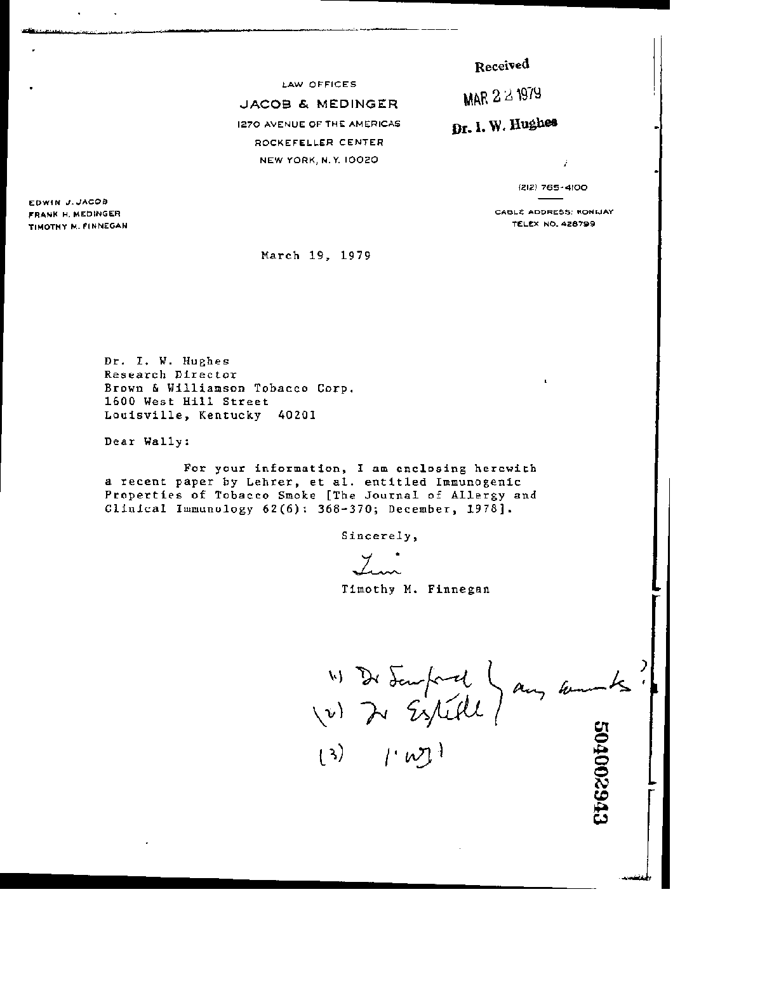

In [4]:
from PIL import Image, ImageDraw, ImageFont

image = Image.open("/kaggle/input/the-rvlcdip-dataset-test/test/letter/0000000700.tif")
image = image.convert("RGB")
image

In [6]:
import pytesseract
import numpy as np

ocr_df = pytesseract.image_to_data(image, output_type='data.frame',config="-c tessedit_char_whitelist=0123456789abcdefghijklmnopqrstuvwxyz -psm 6")
ocr_df = ocr_df.dropna().reset_index(drop=True)
float_cols = ocr_df.select_dtypes('float').columns
ocr_df[float_cols] = ocr_df[float_cols].round(0).astype(int)
ocr_df = ocr_df.replace(r'^\s*$', np.nan, regex=True)
words = ' '.join([word for word in ocr_df.text if str(word) != 'nan'])
words

TesseractError: (1, "Error, unknown command line argument '-psm'")

In [ ]:
coordinates = ocr_df[['left', 'top', 'width', 'height']]
actual_boxes = []
for idx, row in coordinates.iterrows():
    x, y, w, h = tuple(row) # the row comes in (left, top, width, height) format
    actual_box = [x, y, x+w, y+h] # we turn it into (left, top, left+width, top+height) to get the actual box 
    actual_boxes.append(actual_box)

draw = ImageDraw.Draw(image, "RGB")
for box in actual_boxes:
  draw.rectangle(box, outline='red')

image

In [ ]:
dataset_path = "/kaggle/input/the-rvlcdip-dataset-test/test"
labels = [label for label in os.listdir(dataset_path)]
idx2label = {v: k for v, k in enumerate(labels)}
label2idx = {k: v for v, k in enumerate(labels)}
label2idx

In [ ]:
data=pd.DataFrame()
i=0
for label in os.listdir(dataset_path):
    count=0
    for filename in os.listdir(dataset_path+'/'+label):

        if '.ipynb' not in filename and count<200:
            data.at[i,'image_path']=dataset_path+'/'+label+'/'+filename
            data.at[i,'label']=label
            i=i+1
            count=count+1


data = shuffle(data)

In [ ]:
data.head()

In [ ]:
len(data)

In [ ]:
data.columns

In [ ]:
X=data[['image_path']]
y=data[['label']]

In [ ]:
X

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.4, stratify=y)

X_valid,X_test,y_valid,y_test=train_test_split(X_val, y_val, test_size=0.5, stratify=y_val)

In [ ]:
X_train

In [ ]:
train_data=pd.concat([X_train, y_train], axis=1)
valid_data=pd.concat([X_valid, y_valid], axis=1)
test_data=pd.concat([X_test, y_test], axis=1)

In [ ]:
print(len(train_data))
print(len(valid_data))
print(len(test_data))

In [ ]:
train_size=len(train_data)
validation_size=len(valid_data)
test_size=len(test_data)

In [ ]:
from datasets import Dataset

def normalize_box(box, width, height):
     return [
         int(1000 * (box[0] / width)),
         int(1000 * (box[1] / height)),
         int(1000 * (box[2] / width)),
         int(1000 * (box[3] / height)),
     ]

def apply_ocr(example):
        # get the image
        image = Image.open(example['image_path'])

        width, height = image.size
        
        # apply ocr to the image 
        ocr_df = pytesseract.image_to_data(image, output_type='data.frame')
        float_cols = ocr_df.select_dtypes('float').columns
        ocr_df = ocr_df.dropna().reset_index(drop=True)
        ocr_df[float_cols] = ocr_df[float_cols].round(0).astype(int)
        ocr_df = ocr_df.replace(r'^\s*$', np.nan, regex=True)
        ocr_df = ocr_df.dropna().reset_index(drop=True)

        # get the words and actual (unnormalized) bounding boxes
        #words = [word for word in ocr_df.text if str(word) != 'nan'])
        words = list(ocr_df.text)
        words = [str(w) for w in words]
        coordinates = ocr_df[['left', 'top', 'width', 'height']]
        actual_boxes = []
        for idx, row in coordinates.iterrows():
            x, y, w, h = tuple(row) # the row comes in (left, top, width, height) format
            actual_box = [x, y, x+w, y+h] # we turn it into (left, top, left+width, top+height) to get the actual box 
            actual_boxes.append(actual_box)
        
        # normalize the bounding boxes
        boxes = []
        for box in actual_boxes:
            boxes.append(normalize_box(box, width, height))
        
        # add as extra columns 
        assert len(words) == len(boxes)
        example['words'] = words
        example['bbox'] = boxes
        return example


In [ ]:
train_dataset = Dataset.from_pandas(train_data)
updated_train_dataset = train_dataset.map(apply_ocr)

valid_dataset = Dataset.from_pandas(valid_data)
updated_valid_dataset = valid_dataset.map(apply_ocr)

test_dataset = Dataset.from_pandas(test_data)
updated_test_dataset = test_dataset.map(apply_ocr)


updated_train_dataset=updated_train_dataset.remove_columns('__index_level_0__')
updated_valid_dataset=updated_valid_dataset.remove_columns('__index_level_0__')
updated_test_dataset=updated_test_dataset.remove_columns('__index_level_0__')

In [ ]:
from transformers import LayoutLMTokenizer
import torch
from datasets import Features, Sequence, ClassLabel, Value, Array2D

tokenizer = LayoutLMTokenizer.from_pretrained("microsoft/layoutlm-base-uncased")

def encode_example(example, max_seq_length=512, pad_token_box=[0, 0, 0, 0]):
  words = example['words']
  normalized_word_boxes = example['bbox']

  assert len(words) == len(normalized_word_boxes)

  token_boxes = []
  for word, box in zip(words, normalized_word_boxes):
      word_tokens = tokenizer.tokenize(word)
      token_boxes.extend([box] * len(word_tokens))
  
  # Truncation of token_boxes
  special_tokens_count = 2 
  if len(token_boxes) > max_seq_length - special_tokens_count:
      token_boxes = token_boxes[: (max_seq_length - special_tokens_count)]
  
  # add bounding boxes of cls + sep tokens
  token_boxes = [[0, 0, 0, 0]] + token_boxes + [[1000, 1000, 1000, 1000]]
  
  encoding = tokenizer(' '.join(words), padding='max_length', truncation=True)
  # Padding of token_boxes up the bounding boxes to the sequence length.
  input_ids = tokenizer(' '.join(words), truncation=True)["input_ids"]
  padding_length = max_seq_length - len(input_ids)
  token_boxes += [pad_token_box] * padding_length
  encoding['bbox'] = token_boxes
  encoding['label'] = label2idx[example['label']]

  assert len(encoding['input_ids']) == max_seq_length
  assert len(encoding['attention_mask']) == max_seq_length
  assert len(encoding['token_type_ids']) == max_seq_length
  assert len(encoding['bbox']) == max_seq_length

  return encoding



features = Features({
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'attention_mask': Sequence(Value(dtype='int64')),
    'token_type_ids': Sequence(Value(dtype='int64')),
    'label': ClassLabel(names=['refuted', 'entailed']),
    'image_path': Value(dtype='string'),
    'words': Sequence(feature=Value(dtype='string')),
})


In [ ]:
encoded_train_dataset = updated_train_dataset.map(lambda example: encode_example(example), 
                                      features=features)

encoded_train_dataset.set_format(type='torch', columns=['input_ids', 'bbox', 'attention_mask', 'token_type_ids', 'label'])


encoded_valid_dataset = updated_valid_dataset.map(lambda example: encode_example(example), 
                                      features=features)

encoded_valid_dataset.set_format(type='torch', columns=['input_ids', 'bbox', 'attention_mask', 'token_type_ids', 'label'])

encoded_test_dataset = updated_test_dataset.map(lambda example: encode_example(example), 
                                      features=features)

encoded_test_dataset.set_format(type='torch', columns=['input_ids', 'bbox', 'attention_mask', 'token_type_ids', 'label'])

In [ ]:
train_dataloader = torch.utils.data.DataLoader(encoded_train_dataset, batch_size=5, shuffle=True)
validation_dataloader = torch.utils.data.DataLoader(encoded_valid_dataset, batch_size=2, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(encoded_test_dataset, batch_size=1, shuffle=True)

In [ ]:
from transformers import LayoutLMForSequenceClassification
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LayoutLMForSequenceClassification.from_pretrained("microsoft/layoutlm-base-uncased", num_labels=len(label2idx))
model.to(device)

In [ ]:
from transformers import AdamW

optimizer = AdamW(model.parameters(), lr=5e-5)

global_step = 0
num_train_epochs = 50
t_total = len(train_dataloader) * num_train_epochs # total number of training steps 


for epoch in range(num_train_epochs):
  print("Epoch:", epoch)
  running_loss = 0.0
  correct = 0
  model.train()
  for batch in train_dataloader:
      input_ids = batch["input_ids"].to(device)
      bbox = batch["bbox"].to(device)
      attention_mask = batch["attention_mask"].to(device)
      token_type_ids = batch["token_type_ids"].to(device)
      labels = batch["label"].to(device)

      # forward pass
      outputs = model(input_ids=input_ids, bbox=bbox, attention_mask=attention_mask, token_type_ids=token_type_ids,
                      labels=labels)
      loss = outputs.loss

      running_loss += loss.item()
      predictions = outputs.logits.argmax(-1)
      correct += (predictions == labels).float().sum()

      # backward pass to get the gradients 
      loss.backward()

      # update
      optimizer.step()
      optimizer.zero_grad()
      global_step += 1
  
  print("Loss:", running_loss / batch["input_ids"].shape[0])
  accuracy = 100 * correct / train_size
  print("Training accuracy:", accuracy.item())
    
  if epoch%5==0:
    model.eval()

    correct = 0
    for batch in validation_dataloader:
        input_ids = batch["input_ids"].to(device)
        bbox = batch["bbox"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        token_type_ids = batch["token_type_ids"].to(device)
        labels = batch["label"].to(device)
        outputs = model(input_ids=input_ids, bbox=bbox, attention_mask=attention_mask, token_type_ids=token_type_ids)
        predictions = outputs.logits.argmax(-1)
        correct += (predictions == labels).float().sum()

    accuracy = 100 * correct / validation_size
    print("Validation accuracy:", accuracy.item())

In [ ]:
model.eval()
labels_output=[]
predictions_output=[]


correct = 0
for batch in test_dataloader:
    input_ids = batch["input_ids"].to(device)
    bbox = batch["bbox"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    token_type_ids = batch["token_type_ids"].to(device)
    labels = batch["label"].to(device)
    outputs = model(input_ids=input_ids, bbox=bbox, attention_mask=attention_mask, token_type_ids=token_type_ids)
    predictions = outputs.logits.argmax(-1)
#     print(labels)
#     print(predictions)
    correct += (predictions == labels).float().sum()
#     print(correct)

accuracy = 100 * correct / test_size
print("Testing accuracy:", accuracy.item())

In [ ]:
#This model is only trained only around 2000 images in total for identifying 16 categories. 
# the dataset contains more than 45000 images..so we can surely improve the accuracy by increasing the dataset intake
#But unfortunately due to the kaggle runtime limitations i am not able to do it here